In [1]:
! pip install -q kaggle

In [2]:
#upload the kaggle json API token here
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"axiliya","key":"b4cc69bed98c778970fb7fb2036bff4d"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d 'xhlulu/140k-real-and-fake-faces'

100% 3.74G/3.75G [00:54<00:00, 97.7MB/s]
100% 3.75G/3.75G [00:54<00:00, 74.1MB/s]


In [6]:
#unzipping the folder
!unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [7]:
#delete the zip file as it is not needed anymore
!rm 140k-real-and-fake-faces.zip

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd                               #reading, writing and manipulating the data (using tables)
import numpy as np                                #Library for linear algebra and some probabiltity (raw data)
import tensorflow as tf                           #library for numerical computation that makes machine learning faster and easier
from tensorflow import keras                      #we may not add this since keras is already there in tensorflow
from tensorflow.keras.models import Sequential, Model    #To create the sequential layer
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout  #To create the model
from tensorflow.keras.optimizers import Adam, SGD      #Adam optimizer
from keras.preprocessing import image             #used for image classification
from keras.preprocessing.image import ImageDataGenerator  #used to expand the training dataset in order to improve the performance and ability of the model to generalize
import matplotlib.pyplot as plt                   #library to plot graphs
from google.colab import files                    #To be able to upload files
from tensorflow.keras.applications import DenseNet121

In [10]:
train_dir = '/content/real_vs_fake/real-vs-fake/train'
val_dir = '/content/real_vs_fake/real-vs-fake/valid'
test_dir = '/content/real_vs_fake/real-vs-fake/test'

image_size = 64
batch_size = 16

In [11]:
img_datagen = ImageDataGenerator( rescale = 1./255,            # Multiple the colors by a number between 0-1 to process data faster
                                  #  rotation_range=40,           #rotate the images
                                   width_shift_range=0.2,       #fraction of the total width
                                   height_shift_range = 0.2,    #fraction of the total height
                                   zoom_range = 0.2,            #float percent
                                   horizontal_flip=True,        #horizontal flip
                                   fill_mode='nearest')        #add new pixels when the image is rotated or shifted
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = img_datagen.flow_from_directory(
                                train_dir,
                                target_size = (image_size, image_size),
                                batch_size = batch_size,
                                color_mode="rgb",               # for coloured images
                                class_mode = 'binary',
                                shuffle = True,
                                seed=42)

validation_generator = img_datagen.flow_from_directory(
                                val_dir,
                                target_size = (image_size, image_size),
                                batch_size = batch_size,
                                color_mode="rgb",               # for coloured images
                                # shuffle=False,               # for coloured images
                                class_mode = 'binary')            # Specify this is training set

test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size = (image_size, image_size),
                                batch_size = batch_size,
                                color_mode="rgb",
                                shuffle=False,               # for coloured images
                                class_mode = 'binary')            # Specify this is training set

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [12]:
#plotting function

def plotImages(images_arr):
    fig, axes = plt.subplots(1, batch_size, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

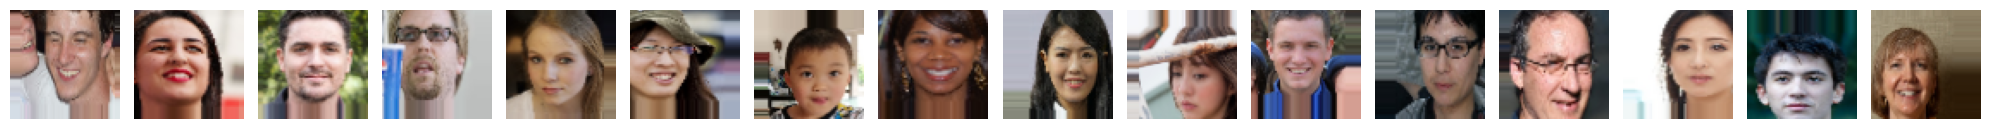

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]


In [13]:
#generate a batch of images and labels from the training set
imgs, labels = next(train_generator)
#displaying example images and their labels 0 is fake and 1 is for real
plotImages(imgs);
print(labels);

In [14]:
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D,
                          Dense, Flatten, Dropout)

In [15]:
#creating the model
def create_DenseNet_Model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(image_size,image_size,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

spoofnet = create_DenseNet_Model()
spoofnet.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [16]:
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                            verbose=1,
                                save_best_only=True,
                           mode='min',
                             moniter='val_loss'
                            )
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_learning_rate, csv_logger]

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history = spoofnet.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=15
                   )


Epoch 1/15
3949/6250 [=================>............] - ETA: 34:58 - loss: 0.6588 - accuracy: 0.6270

In [ ]:
model_path = "/content/drive/MyDrive/DeepfakeDenseNet121/DenseNet121_without_Dropout_lr_0.001"
spoofnet.save(model_path)
print("Saved model to disk")

Saved model to disk


In [ ]:
loss = spoofnet.evaluate(test_generator)

1250/1250 [==============================] - 313s 250ms/step - loss: 0.4880 - accuracy: 0.7721


In [ ]:
predictions = spoofnet.predict(test_generator)
print(predictions)
pred_labels = ((predictions > 0.5)+0).ravel() # (n_images,)
print(pred_labels.shape)
print(pred_labels)

1250/1250 [==============================] - 316s 251ms/step
[[0.56961954]
 [0.2715736 ]
 [0.31056863]
 ...
 [0.9170551 ]
 [0.68498796]
 [0.89296013]]
(20000,)
[1 0 0 ... 1 1 1]


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix,roc_auc_score,precision_recall_curve, classification_report, roc_curve, auc

#Get the confusion matrix
y_test = test_generator.classes

cnf_matrix = confusion_matrix(y_test, pred_labels)
report = classification_report(y_test, pred_labels)
print(cnf_matrix)
print(report)

[[9041  959]
 [3600 6400]]
              precision    recall  f1-score   support

           0       0.72      0.90      0.80     10000
           1       0.87      0.64      0.74     10000

    accuracy                           0.77     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.77      0.77     20000



In [ ]:
#Save the classification report
import json

target_labels = ['fake','real']

dict_report = classification_report(y_test, pred_labels, target_names=target_labels, output_dict=True)
print(dict_report)

dir = model_path
with open(dir+'/reports.txt', 'w') as filehandle:
    json.dump(dict_report, filehandle)

{'fake': {'precision': 0.7152124040819555, 'recall': 0.9041, 'f1-score': 0.798639636058478, 'support': 10000}, 'real': {'precision': 0.8696833808941432, 'recall': 0.64, 'f1-score': 0.7373696641511608, 'support': 10000}, 'accuracy': 0.77205, 'macro avg': {'precision': 0.7924478924880494, 'recall': 0.77205, 'f1-score': 0.7680046501048194, 'support': 20000}, 'weighted avg': {'precision': 0.7924478924880494, 'recall': 0.77205, 'f1-score': 0.7680046501048194, 'support': 20000}}


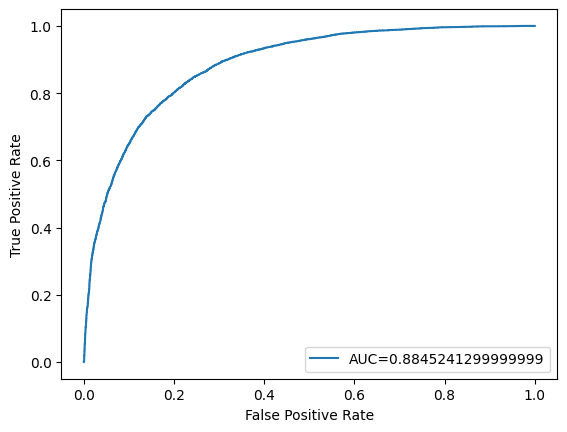

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions)
auc = metrics.roc_auc_score(y_test, predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/DeepfakeDenseNet121/DenseNet121_without_Dropout_lr_0.001")

In [ ]:
predictions = spoofnet.predict(test_generator)
print(predictions)
pred_labels = ((predictions > 0.5)+0).ravel() # (n_images,)
print(pred_labels.shape)
print(pred_labels)

1250/1250 [==============================] - 329s 263ms/step
[[0.56961954]
 [0.2715736 ]
 [0.31056863]
 ...
 [0.9170551 ]
 [0.68498796]
 [0.89296013]]
(20000,)
[1 0 0 ... 1 1 1]


In [ ]:
from keras.preprocessing import image
import numpy as np
from tensorflow import keras

# Load the pre-trained model
model_path = "/content/drive/MyDrive/DeepfakeDenseNet121/DenseNet121_without_Dropout_lr_0.001"
loaded_model = keras.models.load_model(model_path)

# Specify the path to the image you want to classify
image_path_to_check = '/content/Deep.jpeg'

# Load and preprocess the image
img = image.load_img(image_path_to_check, target_size=(64, 64))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values

# Use the loaded model to make predictions
predictions = loaded_model.predict(img)

# Interpret the prediction result
if predictions[0][0] > 0.5:
    print("The image is classified as 'fake'.")
else:
    print("The image is classified as 'real'.")

1/1 [==============================] - 2s 2s/step
The image is classified as 'fake'.
